Calculate taus:

full signal:
1. ACF full
2. iSTTC full
   
trial average style:
1. Pearsonr trial avg
2. iSTTC trial avg
3. iSTTC trial concat

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
#os.chdir(os.path.abspath("C:\\Users\\ipoch\\Documents\\repos\\isttc\\scripts"))
from calculate_tau import fit_single_exp, fit_single_exp_2d, func_single_exp, func_single_exp_monkey
from cfg_global import project_folder_path
os.chdir(current_wd)

In [2]:
dataset_folder = project_folder_path + 'results\\allen_mice\\dataset\\'
#fig_folder = project_folder_path + 'results\\allen_mice\\fig_draft_paper\\'

### Load data

In [3]:
acf_full_df_file = dataset_folder + 'cut_30min\\binned\\acf\\acf_full_50ms_20lags_df.pkl'
acf_full_df = pd.read_pickle(acf_full_df_file)

In [4]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [ ]:
acf_full_df

### Calculate taus

Get all ACF for an area and then fit exponential decay to all points (no mean area ACF)

#### Per area

In [5]:
def calc_population_tau_2d(acf_df_, acf_cols_, start_idx_, func_to_fit_):
    acf_2d = acf_df_[acf_cols_].values
    fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp_2d(acf_2d, start_idx_, func_to_fit_)
    print(f'tau {tau*50}, 95% CI {tau_ci[0]*50},{tau_ci[1]*50}')
    return {'tau_ms':tau*50,
            'tau_lower_ms':tau_ci[0]*50, 
            'tau_upper_ms':tau_ci[1]*50, 
            'fit_r_squared': fit_r_squared, 
            'explained_var': explained_var, 
            'popt': fit_popt}

In [6]:
brain_areas = acf_full_df['ecephys_structure_acronym'].unique()
print(f'brain_areas {brain_areas}')

brain_areas ['VISam' 'LP' 'VISp' 'VISl' 'LGd' 'VISal' 'VISrl' 'VISpm']


In [7]:
acf_full_taus_dict = {}

for area in brain_areas:
    print(f'processing area {area}')
    acf_full_df_area = acf_full_df.query('ecephys_structure_acronym == @area').copy()
    print(f'N units for brain area {area}: {len(acf_full_df_area)}')
    acf_full_taus_dict[area] = calc_population_tau_2d(acf_full_df_area, acf_cols, 2, func_single_exp_monkey)

processing area VISam
N units for brain area VISam: 912
tau 336.07320279984594, 95% CI 299.7883635744778,372.3580420252141
processing area LP
N units for brain area LP: 599
tau 257.53315535707674, 95% CI 232.53166108308338,282.53464963107007
processing area VISp
N units for brain area VISp: 1063
tau 319.66687594979885, 95% CI 295.8336673894851,343.50008451011263
processing area VISl
N units for brain area VISl: 727
tau 309.8334693807622, 95% CI 279.6725253656186,339.99441339590584
processing area LGd
N units for brain area LGd: 254
tau 333.6651172846553, 95% CI 263.42844626777025,403.9017883015403
processing area VISal
N units for brain area VISal: 928
tau 308.2366813382866, 95% CI 279.836254746488,336.63710793008516
processing area VISrl
N units for brain area VISrl: 706
tau 231.96038579674854, 95% CI 209.99032181396763,253.93044977952943
processing area VISpm
N units for brain area VISpm: 586
tau 355.8784731752373, 95% CI 309.0139906114747,402.7429557389998


#### Per unit

### Plots

In [8]:
brain_areas = ['LGd', 'VISp', 'VISl', 'VISrl', 'LP', 'VISal', 'VISpm', 'VISam']
brain_areas_names = ['LGN', 'V1', 'LM', 'RL', 'LP', 'AL', 'PM', 'AM']

#### Per area with confidence intervals

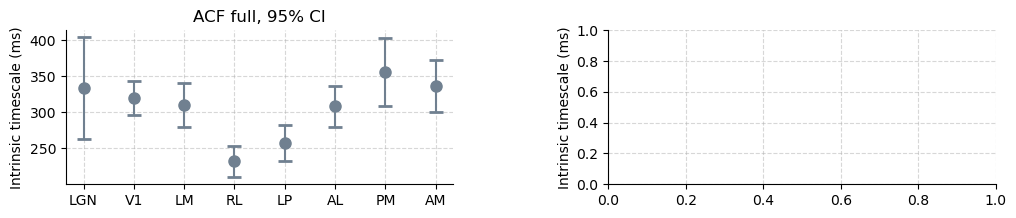

In [9]:
acf_full_conditions = brain_areas

acf_full_tau = [acf_full_taus_dict[c]['tau_ms'] for c in acf_full_conditions]
acf_full_tau_lower = [acf_full_taus_dict[c]['tau_lower_ms'] for c in acf_full_conditions]
acf_full_tau_upper = [acf_full_taus_dict[c]['tau_upper_ms'] for c in acf_full_conditions]
acf_full_error_bars = [np.array(acf_full_tau) - np.array(acf_full_tau_lower), np.array(acf_full_tau_upper) - np.array(acf_full_tau)]

fig, axes = plt.subplots(1, 2, figsize=(12, 2), sharey=False)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

#colors = [color_pearson_trail_avg, color_sttc_trail_avg, color_sttc_trail_concat, 'k']

for i, (cond, tau, err_low, err_high) in enumerate(zip(acf_full_conditions, acf_full_tau, acf_full_error_bars[0], acf_full_error_bars[1])):
    axes[0].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=8, color='slategray')
axes[0].set_xticks(acf_full_conditions)
axes[0].set_xticklabels(brain_areas_names)
axes[0].set_title('ACF full, 95% CI')

# for i, (cond, tau, err_low, err_high, col) in enumerate(zip(pfp_conditions, pfp_tau, pfp_error_bars[0], pfp_error_bars[1], colors)):
#     axes[1].errorbar(cond, tau, yerr=[[err_low], [err_high]], fmt='o', capsize=5, capthick=2, markersize=8, color=col)
# axes[1].set_xticks(pfp_conditions)
# axes[1].set_title('PFp, 95% CI')

for ax in axes.flat:
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_ylabel('Intrinsic timescale (ms)')
    # ax.set_xticklabels(['Pearson trial avg', 'STTC trial avg', 'STTC trial concat', 'Fascianelli et al.2019 \n Figure 2'], 
    #                    rotation=45, ha='right', fontsize=8)
    # ax.set_ylim([180, 280])
    

sns.despine()

# if save_fig:
#     fig.savefig(fig_folder + 'fig2_repr_no_empty_1000ms_population_fit.png', bbox_inches='tight', dpi=300)
#     fig.savefig(fig_folder + 'fig2_repr_no_empty_1000ms_population_fit.svg', bbox_inches='tight')